<a href="https://colab.research.google.com/github/Joshua-Ogbebor/Transet-Project/blob/main/Deep_Net_227_BinaryClass_Binarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import os

from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torchvision.transforms
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

cwd = os.getcwd()

from skimage.data import page
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)


## Create Training & Validation Folder and Preview

In [ ]:
def create_training_data():
    """ This function creates the Training and Validation dataset for data saved in a folder in the 
    current working directory. The Dataset folder is expected to contain labelled images in subfolders
    The number of subfolders indicates the number of classes while the name of the subfolders are the classnames """
    cwd = os.getcwd()
    base_dir = cwd
    dataset_dir = base_dir + "/Dataset"
    
    list_dirs = [f.path for f in os.scandir(dataset_dir) if f.is_dir()]
    Num_classes = len(list_dirs)
    for dirs in list_dirs:
        class_name = dirs.split('/')[-1]
        
        # Training set
        train_dir = f"{dataset_dir}/train/{class_name}"                    # Create folder names
        shutil.move(dirs, train_dir)
        
        # Validation set
        val_dir = f"{dataset_dir}/val/{class_name}" 
        os.makedirs(val_dir)
        for f in os.listdir(train_dir):
            if random.random() > 0.80: #generates a random float uniformly in the semi-open range [0.0, 1.0)
                shutil.move(f'{train_dir}/{f}', val_dir)
                
        # Print number of classes                
        num_T=len(os.listdir( train_dir ))
        num_V=len(os.listdir( val_dir ))
        
        print("{:s}: {:.0f} training images and {:.0f} validation images ({:.1f}%) ".format(class_name, num_T, num_V, 100*num_V/(num_T+num_V)))   
    print("There are {:.0f} Classes.".format(Num_classes))
    return Num_classes


In [ ]:
Num_classes = create_training_data()

Check out Binarization Techniques

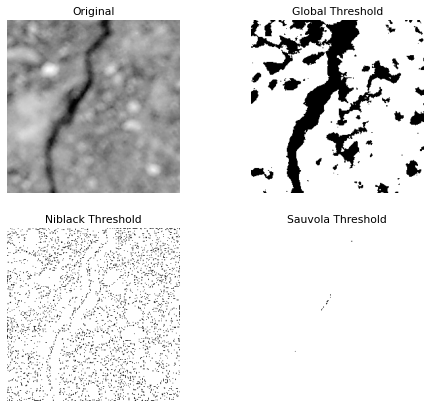

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.size'] = 9


image = Image.fromarray(cv2.imread('Test_Images/img_98.png'))

transform = transforms.Compose([
transforms.Grayscale(),

transforms.CenterCrop(256),
transforms.ToTensor()
])

image = transform(image)


binary_global = image > threshold_otsu(image.numpy())

window_size = 131
thresh_niblack = threshold_niblack(image.numpy(), window_size=window_size, k=0.8)
thresh_sauvola = threshold_sauvola(image.numpy(), window_size=window_size)

binary_niblack = image.numpy() > thresh_niblack
binary_sauvola = image.numpy() > thresh_sauvola

plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.imshow(image.squeeze(0), cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Global Threshold')
plt.imshow(binary_global.squeeze(0),cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(binary_niblack.transpose(1,2,0), cmap=plt.cm.gray)
plt.title('Niblack Threshold')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(binary_sauvola.transpose(1,2,0), cmap=plt.cm.gray)
plt.title('Sauvola Threshold')
plt.axis('off')

plt.show()

## *View Training Dataset and Compute Mean, std of the training Dataset


In [ ]:
## Create the data loader
from numpy import asarray
def Binarization_S (image, window_size = 25):
    #binary_global = image > threshold_otsu(image)
    #thresh_niblack = threshold_niblack(image, window_size=window_size, k=0.8)
    thresh_sauvola = threshold_sauvola(image, window_size=window_size)
    #binary_niblack = image > thresh_niblack
    binary_sauvola = image > thresh_sauvola
    #B_S = (np.multiply(binary_sauvola, 1.0)#.astype(float))
    B_S = (Image.fromarray(binary_sauvola))
    return  B_S

class Binarization(object):
    def __init__(self, window_size):
        self.windowsize = window_size
        
    def __call__(self, image, window_size = 25):
        binary_sauvola=Binarization_S(asarray(image), window_size)
        trans = transforms.Compose([transforms.ToTensor()])
        return (binary_sauvola)#.astype(float)#.to(torch.float)

chosen_transforms = {'train': transforms.Compose([
        #torchvision.
        transforms.Resize(size=256),
        transforms.Grayscale(),
        Binarization(window_size = 131),#transforms.RandomRotation(degrees=10),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
    #transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=<InterpolationMode.BILINEAR: 'bilinear'>, fill=0)
        #transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        #transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        #torchvision.transforms.Grayscale
        transforms.Resize(256),
        transforms.Grayscale(),
        Binarization(window_size = 131),#transforms.CenterCrop(227),
        transforms.ToTensor(),
        #transforms.Normalize(mean_nums, std_nums)
]),
}
 

def target_to_oh(target):
    #NUM_CLASS = 2  # hard code here
    one_hot = torch.eye(Num_classes)[target]
    return one_hot

def load_dataset(format, batch_size=100):
    data_path = os.path.join(dataset_dir, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format],target_transform=target_to_oh
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,                                
        shuffle=True
    )
    return  data_loader, len(dataset), dataset.classes

def compute_mean_n_deviation():
    """This funtion calculates the mean and standard deviation of a dataset. It could be heavy on processor
    depending on the Batchsize"""
    mean = 0.0
    for images, _ in Train_loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    mean_nums = mean / len(Train_loader.dataset)
        
    var = 0.0
    for images, _ in Train_loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1))**2).sum([0,2])
    std_nums = torch.sqrt(var / (len(Train_loader.dataset)*256*256))  #hardcode here
    
    return mean_nums, std_nums

In [ ]:
Train_loader, train_size, class_names = load_dataset('train')                  # Batchsize
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)

inputs, classes = next(iter(Train_loader))
print(inputs.shape, classes.shape)

# View using TensorBoard

writer=SummaryWriter()
grid = torchvision.utils.make_grid(inputs)
writer.add_image("inputs", grid)
writer.close()

# Skip Mean and STD

In [ ]:
mean_nums, std_nums = compute_mean_n_deviation()
print(std_nums, mean_nums)   

In [ ]:
print(std_nums, mean_nums)   

tensor([28626.5215, 28484.8730, 28131.4219]) tensor([0.6405, 0.6374, 0.6295])


In [ ]:
# 227 :std=tensor([15.8585, 15.9218, 15.9502]) mean=tensor([0.6895, 0.6922, 0.6935])
# 256 : std=tensor([28682.5078, 28546.3672, 28195.0879]) MeAN= tensor([0.6405, 0.6375, 0.6296]

## ***View the Training Dataset using Matplotlib instead

In [ ]:
# Visualize using matplotlib images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([mean_nums])
    #std = np.array([std_nums])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)  # Pause a bit so that plots are updated
    
# Grab some of the training data to visualize
# Construct a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(100,100))

imshow(out, title=[x.data.numpy() for x in classes])

### Cuda Viola

In [ ]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Set up Model¶

In [ ]:

class CNNet(nn.Module):                                                       
    def __init__(self):                                                           
        super(CNNet, self).__init__()                                            
        
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=20, stride=2),                           
            nn.BatchNorm2d(num_features=24))
        self.P1 = nn.MaxPool2d(kernel_size=7, stride=2)
        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=15, stride=2),
            nn.BatchNorm2d(num_features=48))
        self.P2 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.C3 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=10, stride=2),
            nn.BatchNorm2d(num_features=96))                                 # Check if BatchNorm1d              
            
        self.DropOut = nn.Dropout()                                          # This is just 1d lol
        self.ReLu = nn.ReLU()                                                          #
        self.C4 = nn.Conv2d(in_channels=96, out_channels=2, kernel_size=1, stride=1)                   # Check if Conv1d
        #self.Linear = nn.Linear(in_features=4, out_features=2)
        
    def forward(self,N):
        N = self.C1(N)
        N = self.P1(N)
        N = self.C2(N)
        N = self.P2(N)
        N = self.C3(N)
        N = self.DropOut(N)
        N = self.ReLu(N)
        Output = self.C4(N)
        #Output = self.Linear(Output)
        return Output
    
        
T1=CNNet() 
writer=SummaryWriter()
writer.add_graph(T1, inputs)
writer.close()
 
# Convert model to be used on GPU do this before optimizer
T1.to(device)

print (T1)


print(summary(T1, (1, 256, 256)))

### Training parameters

In [ ]:
# Define Optimizer and Loss Function

# learning rate decay.  change the learning rate dynamically- the schedular 
#@ IN THE FIRST epoch, the learning rate was 0.01, then the learning rate in epoch 10 would be 0.05. 

import torch.optim as optim
# torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
optimizer = optim.SGD(T1.parameters(), lr=0.01, momentum=0.9, dampening=0, weight_decay=0.0001)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


criterion = nn.BCEWithLogitsLoss().cuda()            


# Load data againtorch.(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
dataloaders = {}
dataset_sizes = {}
batch_size = 100                                                                                 #100
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'Cracked', 1:'Uncracked'}

print(class_names)

In [ ]:
def idx2class():
    idx=0
    for i in class_names:
        idx_to_class[idx] = i
        idx=idx+1
    print (idx_to_class)
    return idx_to_class


idx_to_class = idx2class()

def get_num_correct(pred, labels):
    pred_c, ind_pred = torch.max(pred,1)
    labels_c, ind_label = torch.max(labels,1)
    
    return ind_pred.eq(ind_label).sum().item()

# Train


In [ ]:

def get_num_correct(pred, labels):
    pred_c, ind_pred = torch.max(pred,1)
    labels_c, ind_label = torch.max(labels,1)
    
    return ind_pred.eq(ind_label).sum().item()

def train_model(model, criterion, optimizer, scheduler, num_epochs=60):
    writer=SummaryWriter()
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:                                          ## where is phase from
            if phase == 'train':
                #scheduler.step()                                                             #######
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            #training starts...
            print('Iterating through data...')
            # 
            for inputs, labels in dataloaders[phase]:
                

                inputs = inputs.to(device)
                labels = labels.to(device)
                # Zero the accumulated gradients for each step,
                optimizer.zero_grad()
                
                # Time to carry out the forward training poss
                with torch.set_grad_enabled(phase == 'train'): #This is false for validation
                    outputs = model(inputs)
                    outputs=outputs.squeeze(3)
                    outputs=outputs.squeeze(2)
                    #print(outputs.size())
                    
                    #the loss...
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # this is the back-propragation step. 
                        #writer.add_scalar('Loss/train', loss.item(), epoch)
                        optimizer.step()
                        # optimizer updates the model paramters...
      
                # combine our model losses and compute the wrongly classified examples
                current_loss += loss.item() * inputs.size(0)
                current_corrects += get_num_correct(outputs,labels)
            # compute the loss and accuracy for each of our epoch
            if phase == 'train':
                scheduler.step() 
            epoch_loss = (1.0*current_loss) / dataset_sizes[phase]
            epoch_acc = (1.0* current_corrects)/ dataset_sizes[phase]
            
            if phase == 'val':
                #writer.add_scalar("Val Loss", current_loss, epoch)
                Val_epoch_loss=epoch_loss
                Val_epoch_acc=epoch_acc
                writer.add_scalar("Validation Loss", epoch_loss, epoch)
                writer.add_scalar("Validation Accuracy", epoch_acc,epoch)#total_correct/ len(train_set), epoch)
            if phase == 'train':
                #writer.add_scalar("Train Loss", current_loss, epoch)
                Trn_epoch_loss=epoch_loss
                Trn_epoch_acc=epoch_acc
                writer.add_scalar("Training Loss", epoch_loss, epoch)
                writer.add_scalar("Training Accuracy", epoch_acc, epoch)#total_correct/ len(train_set), epoch)
                
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    #writer.add_scalars
    writer.close()
    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    PATH_dICT = './cifar_dICT_net.pth'
    PATH_mODEL = './cifar__mODEL_net-a TextEdit hi.txt.pth'

    torch.save(model.state_dict(), PATH_dICT)
    torch.save(model, PATH_mODEL)
    
    return model


def visualize_model(model, num_images=20):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            val, ind =torch.max(output,1)
            #print(val,ind)
            
            

            for j in range(inputs.size()[0]):
                images_handeled += 1
                class_name = idx_to_class[ind.squeeze(1)[j].item()]
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_name))
                cv2.imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Memory


In [ ]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
f

19615232

In [ ]:
base_model = train_model(T1, criterion, optimizer, exp_lr_scheduler, num_epochs=60) 
#base_model=base_model2
visualize_model(base_model)
plt.show()
# an epoch is the total time during which one training step completes. In other words, it is the total
# time that our model takes to process the input data once...

Epoch 1/55
----------
Iterating through data...
train Loss: 0.0584 Acc: 0.9853
Iterating through data...
val Loss: 0.0247 Acc: 0.9946

Epoch 2/55
----------
Iterating through data...
train Loss: 0.0251 Acc: 0.9927
Iterating through data...
val Loss: 0.0303 Acc: 0.9911

Epoch 3/55
----------
Iterating through data...
train Loss: 0.0201 Acc: 0.9944
Iterating through data...
val Loss: 0.0475 Acc: 0.9861

Epoch 4/55
----------
Iterating through data...
train Loss: 0.0159 Acc: 0.9955
Iterating through data...
val Loss: 0.0293 Acc: 0.9911

Epoch 5/55
----------
Iterating through data...
train Loss: 0.0143 Acc: 0.9959
Iterating through data...
val Loss: 2.9930 Acc: 0.4951

Epoch 6/55
----------
Iterating through data...
train Loss: 0.0112 Acc: 0.9971
Iterating through data...
val Loss: 0.6373 Acc: 0.8347

Epoch 7/55
----------
Iterating through data...
train Loss: 0.0102 Acc: 0.9971
Iterating through data...
val Loss: 2.9135 Acc: 0.5820

Epoch 8/55
----------
Iterating through data...
train L

nn.CrossEntrolyLoss expects a model output in the shape [batch_size, nb_classes, *additional_dims] and a target in the shape [batch_size, *additional_dims] containing the class indices in the range [0, nb_classes-1].

## Save?


In [ ]:
PATH_dICT = './cifar_dICT_net2.pth'
PATH_mODEL = './cifar__mODEL_net2.pth'

torch.save(base_model.state_dict(), PATH_dICT)
torch.save(base_model, PATH_mODEL)


## Load? 

In [ ]:
PATH_mODEL = './cifar__mODEL_net.pth'
model_m = torch.load(PATH_mODEL)
model_m.eval()
base_model = model_m

In [ ]:
PATH_dICT = './cifar_dICT_net.pth'
model_d = T1
model_d.load_state_dict(torch.load(PATH_dICT))
model_d.eval()
base_model = model_m

# Prediction Function and Sliding Window

In [ ]:
idx_to_class = {0:'Cracked', 1:'Uncracked'}

def predict(model, test_image, print_class = False):
     # it uses the model to predict on test_image...
    transform = chosen_transforms['val']
     
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available(): # checks if we have a gpu available
        test_image_tensor = test_image_tensor.view(1, 1, 256, 256).cuda() #Hard code
    else:
        test_image_tensor = test_image_tensor.view(1, 1, 256, 256)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        # this computes the output of the model
        out = model(test_image_tensor)
        # this computes the probability of each classes.
        pred, ind = torch.max(out,1)
        # we choose the top class. That is, the class with highest probability
        #topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[ind.item()]
        if print_class:
            print("Output class :  ", class_name)
    return class_name


def predict_on_crops(input_image, height=256, width=256, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    print(imgheight, imgwidth, channels)
    imH=256*round(imgheight/256)
    imW=256*round(imgwidth/256)
    im=cv2.resize(im, (imW,imH), interpolation = cv2.INTER_AREA)
    imgheight, imgwidth, channels = im.shape
    print(imgheight, imgwidth, channels)
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            predicted_class = predict(base_model,Image.fromarray(a))
            ## save image
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class[0] == 'C':
                color = (0,0, 255)                             #Blue
            else:
                color = (0, 255, 0)                             #Green
                
                ##############
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 2.1,  1, cv2.LINE_AA) ##############
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0) ###############################
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

3078 5472 3
3072 5376 3


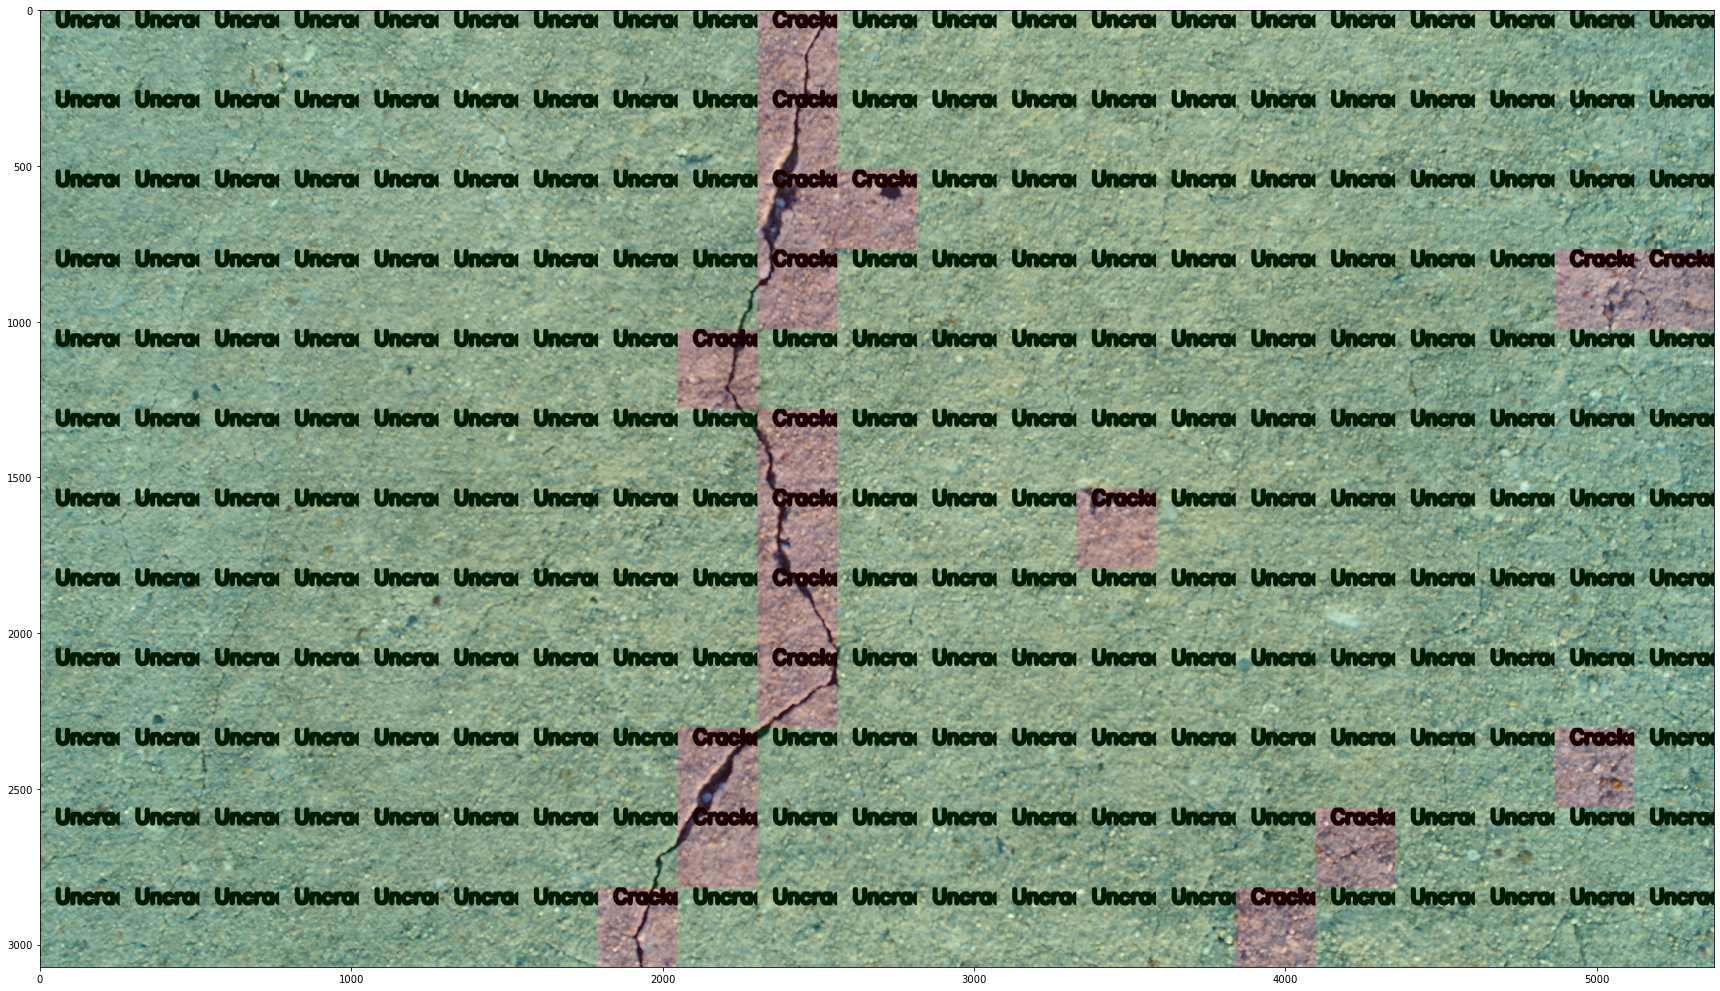

In [ ]:
plt.figure(figsize=(30,30))
output_image = predict_on_crops('Test_Images/DJI_0095.JPG', 256, 256)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

3078 5472 3
3072 5376 3


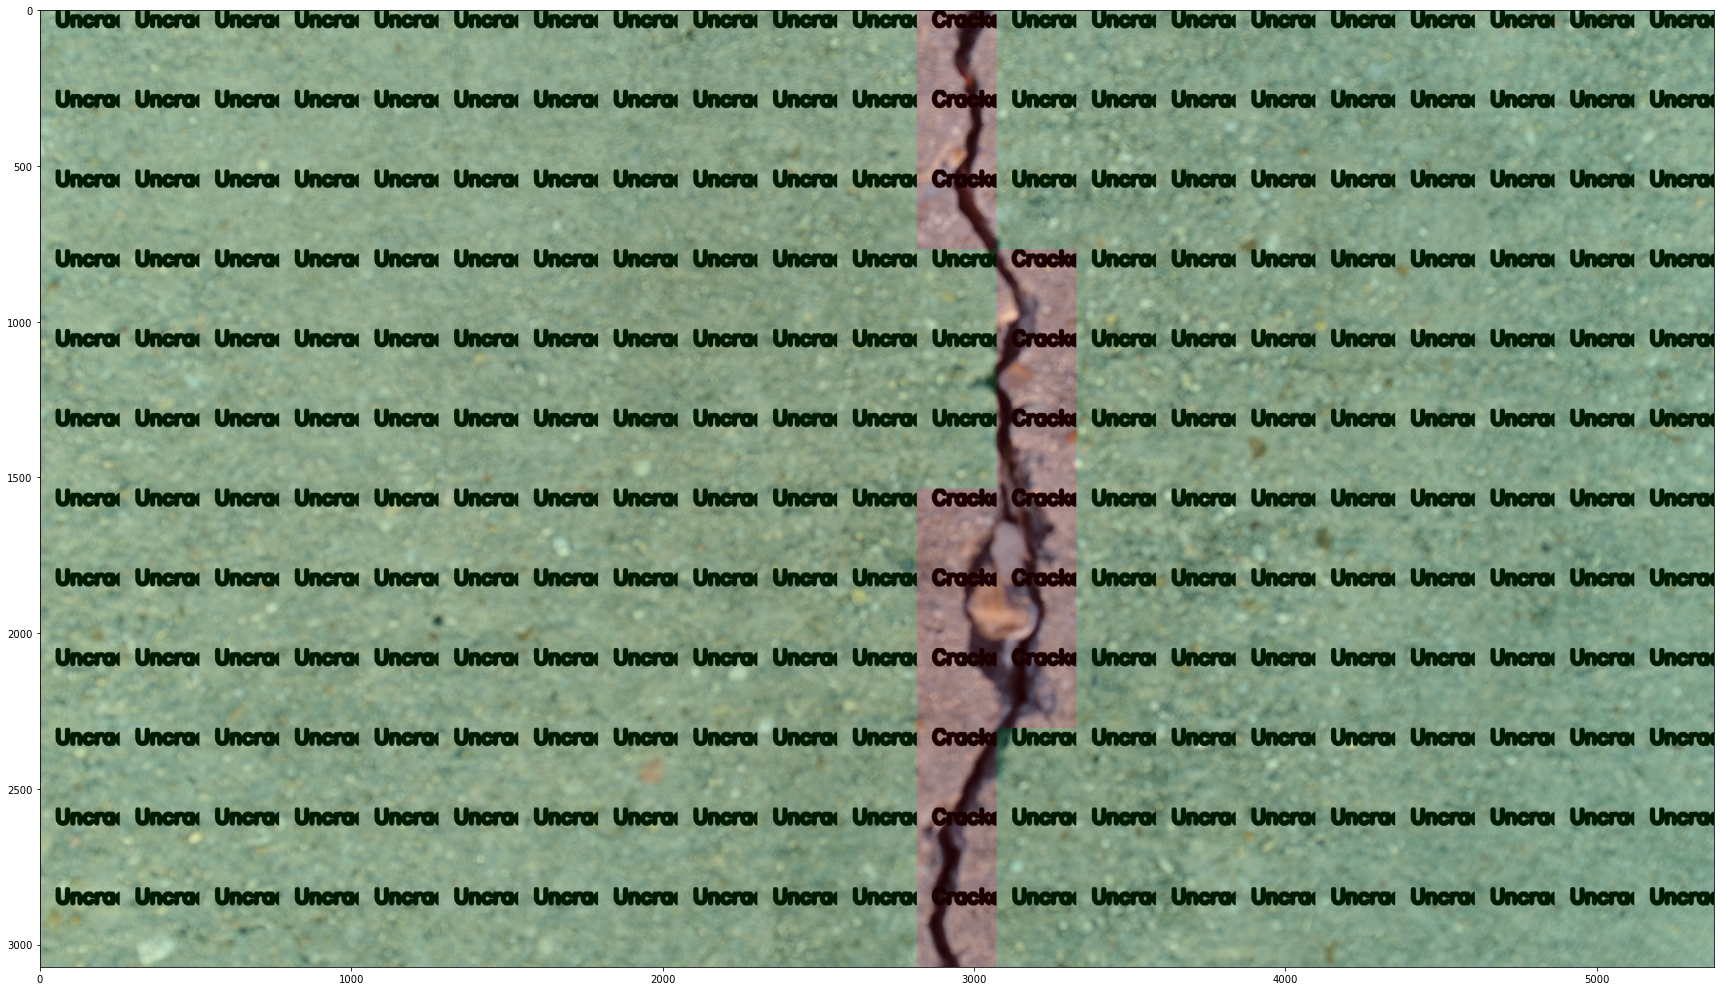

In [ ]:
plt.figure(figsize=(30,30))
output_image = predict_on_crops('Test_Images/DJI_0100.JPG', 256, 256)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))